# Training

---

## Background

In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.  The minimal required dataset for this is a history of user item ratings.  In our case, we'll use 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

![image](https://developers.google.com/machine-learning/recommendation/images/Matrixfactor.svg)

Matrix factorization has been extended and genarlized with deep learning and embeddings.  These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  This notebook will fit a neural network-based model to generate recommendations for the Amazon video dataset.  It will start by exploring our data in the notebook and even training a model on a sample of the data.  Later we'll expand to the full dataset and fit our model using a SageMaker managed training cluster.  We'll then deploy to an endpoint and check our method.


In [ ]:
# Import packages
import os
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE

import json
import matplotlib.pyplot as plt


In [276]:
algo_name = 'gluon-MF'
dataset_name = 'book-crossing'
dataset_name = 'ml-100k'


In [277]:
from sagemaker import get_execution_role
from sagemaker.session import Session

sagemaker_session = Session()
region = sagemaker_session.boto_session.region_name

# S3 bucket for saving files. Feel free to redefine this variable to the bucket of your choice.
bucket = sagemaker_session.default_bucket()

prefix = f'sagemaker/DEMO-recsys-{algo_name}-{dataset_name}'

train_prefix = f'{prefix}/train'
output_prefix = f'{prefix}/output'

# Bucket location where your custom code will be saved in the tar.gz format.
custom_code_upload_location = f's3://{bucket}/{prefix}/code'

# Bucket location where results of model training are saved.
model_artifacts_location = f's3://{bucket}/{prefix}/artifacts'

# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()


---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training

In [ ]:
# !pygmentize gluon_recommender.py


### Train Locally

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

In [ ]:
%%time

import gluon_recommender
import importlib
importlib.reload(gluon_recommender)

channel_input_dirs = {
    'train': f'data/{dataset_name}/interactions_train.csv.gz',
    'test': f'data/{dataset_name}/interactions_test.csv.gz',
    'user_index': f'data/{dataset_name}/user_index.csv.gz',
    'item_index': f'data/{dataset_name}/item_index.csv.gz',
}

hps = {
    'num-embeddings': 64, 
    'opt': 'sgd', 
    'lr': 0.02, 
    'momentum': 0.9, 
    'wd': 0.,
    'epochs': 3,
    'num-gpu': 1,
    'batch-size': 1024,
}

net = local_test_net, local_customer_index, local_product_index = gluon_recommender.train(
    channel_input_dirs, 
    hps,
    ['local'],
    1
)

gluon_recommender.save(net, f'model/gluon_MF/{dataset_name}')



We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

However, with just a 64 dimensional embedding, it took 7 minutes to run just 3 epochs.  If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.

#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [154]:
df_item_index['u6_predictions'] = trained_net(
    nd.array([6] * df_item_index.shape[0]).as_in_context(ctx), 
    nd.array(df_item_index['_ITEM_IDX'].values).as_in_context(ctx)
).asnumpy()
df_item_index.sort_values('u6_predictions', ascending=False)

,ITEM_ID,_ITEM_IDX,u6_predictions
199,550,199,0.608147
280,217,280,0.513579
291,184,291,0.498781
207,1028,207,0.489867
68,475,68,0.487857
...,...,...,...
761,925,761,0.041779
160,133,160,0.039486
1056,1187,1056,0.038988
484,469,484,0.037088


Now let's compare this to the predictions for another user (we'll try user #7).

In [155]:
df_item_index['u7_predictions'] = trained_net(
    nd.array([7] * df_item_index.shape[0]).as_in_context(ctx), 
    nd.array(df_item_index['_ITEM_IDX'].values).as_in_context(ctx)
).asnumpy()
df_item_index.sort_values('u7_predictions', ascending=False)


,ITEM_ID,_ITEM_IDX,u6_predictions,u7_predictions
199,550,199,0.608147,0.499339
94,161,94,0.481831,0.431780
280,217,280,0.513579,0.420977
487,207,487,0.475296,0.411387
207,1028,207,0.489867,0.406062
...,...,...,...,...
738,364,738,0.045658,0.020925
1056,1187,1056,0.038988,0.020903
0,50,0,0.042849,0.018411
613,456,613,0.045958,0.016818


The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

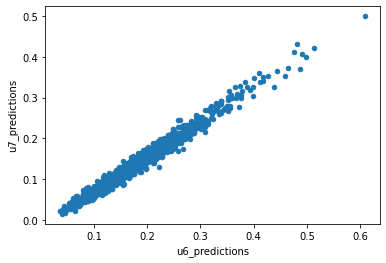

In [156]:
df_item_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()


### Move Data

Holding our data in memory works fine when we're interactively exploring a sample of data, but for larger, longer running processes, we'd prefer to run them in the background with SageMaker Training.  To do this, let's move the dataset to S3 so that it can be picked up by SageMaker training.  This is perfect for use cases like periodic re-training, expanding to a larger dataset, or moving production workloads to larger hardware.

In [160]:
s3_bucket = boto3.Session().resource('s3').Bucket(bucket)
s3_bucket.Object(f'{train_prefix}/interactions_train.csv.gz').upload_file(f'data/{dataset_name}/interactions_train.csv.gz')
s3_bucket.Object(f'{train_prefix}/interactions_test.csv.gz').upload_file(f'data/{dataset_name}/interactions_test.csv.gz')
s3_bucket.Object(f'{train_prefix}/user_index.csv.gz').upload_file(f'data/{dataset_name}/user_index.csv.gz')
s3_bucket.Object(f'{train_prefix}/item_index.csv.gz').upload_file(f'data/{dataset_name}/item_index.csv.gz')


### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [269]:
channel_input_dirs = {
    'train': f's3://{bucket}/{prefix}/train/interactions_train.csv.gz',
    'test': f's3://{bucket}/{prefix}/train/interactions_test.csv.gz',
    'user_index': f's3://{bucket}/{prefix}/train/user_index.csv.gz',
    'item_index': f's3://{bucket}/{prefix}/train/item_index.csv.gz',
}


hps = {
    'num-embeddings': 512, 
    'opt': 'sgd', 
    'lr': 0.02, 
    'momentum': 0.9, 
    'wd': 0.,
    'epochs': 10,
    'num-gpu': 1,
    'batch-size': 1024,
}

train_instance_type = "ml.p3.2xlarge"
use_spot_instances = True
max_run = 600
max_wait = 1200 if use_spot_instances else None

In [270]:
from sagemaker.mxnet import MXNet

estimator = MXNet(
    entry_point="gluon_MF.py",
    py_version='py37',
#     image_uri=image_uri,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait,
    instance_type=train_instance_type,
    instance_count=1,
    output_path=model_artifacts_location,
    code_location=custom_code_upload_location,
    role=role,
    hyperparameters=hps,
    framework_version='1.8',
)

estimator.fit(channel_input_dirs, wait=False)
training_job_name = estimator.latest_training_job.name

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: mxnet-training-2020-12-13-19-41-18-836


ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: No S3 objects found under S3 URL "s3://sagemaker-us-east-1-533025023261/sagemaker/DEMO-recsys-object2vec-ml-100k/train/interactions_train.csv.gz" given in input data source. Please ensure that the bucket exists in the selected region (us-east-1), that objects exist under that S3 prefix, and that the role "arn:aws:iam::533025023261:role/service-role/AmazonSageMaker-ExecutionRole-20201207T125027" has "s3:ListBucket" permissions on bucket "sagemaker-us-east-1-533025023261".

In [ ]:
attached_estimator = MXNet.attach(training_job_name)

In [ ]:
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
print(len(users), 'descriptions of', max_userid, 'users loaded.')


In [57]:
# Save into users.csv
df_users_reg.to_csv(USERS_REG_CSV_FILE, 
             sep=',', 
             header=True, 
             encoding='latin-1',
             columns=['USER_ID', 'jobfunc', 'country', 'role'])
print('Saved to', USERS_REG_CSV_FILE)


Saved to users_reg.csv


In [81]:
# Read the Ratings File
import numpy as np
df_interactions = pd.read_csv(os.path.join(RAW_DATA_DIR, INTERACT_DATA_FILE), 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    header=0,
                    names=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'event_type', 'event_value'])

df_interactions = df_interactions.fillna(method='ffill')
df_interactions.TIMESTAMP = df_interactions.TIMESTAMP.astype('int32')
df_interactions

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
0,docu-173226,Prod-181146,1475248352,RFI,4
1,docu-173226,Prod-594273,1475248547,RFI,4
2,docu-173226,Prod-553244,1475248777,RFI,4
3,docu-173226,Prod-512376,1475248828,RFI,4
4,docu-173226,Prod-35859,1475248950,RFI,4
...,...,...,...,...,...
9450314,docu-201094,Prod-483061,1600787512,RFI,4
9450315,docu-201094,Prod-250002,1600787512,RFI,4
9450316,docu-201094,Prod-600148,1600787512,RFI,4
9450317,docu-110539,Prod-583985,1600787512,RFI,4


In [82]:
df_interactions = df_interactions.loc[df_interactions['event_type']=='Page_Visit']
df_interactions

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
157,06jc13b905hvwha820,Prod-781752,1588799001,Page_Visit,1
158,06aayj9805ap16yx20,Prod-58541,1588799043,Page_Visit,1
159,07u9qw38052qx39e20,Prod-976899,1588799067,Page_Visit,1
160,06gc50z205nyaxx220,Prod-1004637,1588799071,Page_Visit,1
161,07u9qw38052qx39e20,Prod-976899,1588799084,Page_Visit,1
...,...,...,...,...,...
9450249,221iliir09jo28ha20,Prod-245816,1600787450,Page_Visit,1
9450250,22eb9h1509rbbg8j20,Prod-1249083,1600787456,Page_Visit,1
9450251,22eb9h1509rbbg8j20,Prod-1254738,1600787474,Page_Visit,1
9450252,22c3o1tn09gauy5520,Prod-503268,1600787507,Page_Visit,1


In [83]:
# Read the Ratings File
df_users_unreg = df_interactions.loc[~df_interactions.USER_ID.isin(df_users_reg.USER_ID), ['USER_ID']]

df_users_unreg

,USER_ID
157,06jc13b905hvwha820
158,06aayj9805ap16yx20
159,07u9qw38052qx39e20
160,06gc50z205nyaxx220
161,07u9qw38052qx39e20
...,...
9450249,221iliir09jo28ha20
9450250,22eb9h1509rbbg8j20
9450251,22eb9h1509rbbg8j20
9450252,22c3o1tn09gauy5520


In [84]:
# Save into users.csv
df_users_unreg.to_csv(USERS_UNREG_CSV_FILE, 
             sep=',', 
             header=True, 
             encoding='latin-1',
             columns=['USER_ID'])
print('Saved to', USERS_UNREG_CSV_FILE)


Saved to users_unreg.csv


In [85]:
df_interactions_reg = df_interactions.loc[df_interactions.USER_ID.isin(df_users_reg.USER_ID)]
df_interactions_reg

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
982,docu-201466,Prod-909983,1588819197,Page_Visit,1
1051,docu-185788,Prod-962677,1588821731,Page_Visit,1
1056,docu-185788,Prod-1243937,1588821802,Page_Visit,1
1057,docu-185788,Prod-962677,1588821805,Page_Visit,1
1089,docu-195395,Prod-518868,1588822541,Page_Visit,1
...,...,...,...,...,...
9450068,docu-180179,Prod-1041055,1600784219,Page_Visit,1
9450133,docu-227020,Prod-817156,1600785021,Page_Visit,1
9450159,docu-227020,Prod-817156,1600785126,Page_Visit,1
9450196,docu-180179,Prod-971514,1600785536,Page_Visit,1


In [ ]:
# Set max_userid to the maximum user_id in the ratings
max_userid = df_interactions['user_id'].drop_duplicates().max()
# Set max_movieid to the maximum movie_id in the ratings
max_movieid = df_interactions['item_id'].drop_duplicates().max()

# Process ratings dataframe for Keras Deep Learning model
# Add user_emb_id column whose values == user_id - 1
ratings['user_emb_id'] = ratings['user_id'] - 1
# Add movie_emb_id column whose values == movie_id - 1
ratings['movie_emb_id'] = ratings['movie_id'] - 1

print(len(ratings), 'ratings loaded')

In [86]:
# Save into ratings.csv
df_interactions_reg.to_csv(INTERACT_REG_CSV_FILE, 
               sep=',', 
               header=True, 
               encoding='latin-1', 
               columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'event_type', 'event_value'])
print('Saved to', INTERACT_REG_CSV_FILE)

Saved to interactions_reg.csv


In [87]:
df_interactions_unreg = df_interactions.loc[df_interactions.USER_ID.isin(df_users_unreg.USER_ID)]
df_interactions_unreg

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
157,06jc13b905hvwha820,Prod-781752,1588799001,Page_Visit,1
158,06aayj9805ap16yx20,Prod-58541,1588799043,Page_Visit,1
159,07u9qw38052qx39e20,Prod-976899,1588799067,Page_Visit,1
160,06gc50z205nyaxx220,Prod-1004637,1588799071,Page_Visit,1
161,07u9qw38052qx39e20,Prod-976899,1588799084,Page_Visit,1
...,...,...,...,...,...
9450249,221iliir09jo28ha20,Prod-245816,1600787450,Page_Visit,1
9450250,22eb9h1509rbbg8j20,Prod-1249083,1600787456,Page_Visit,1
9450251,22eb9h1509rbbg8j20,Prod-1254738,1600787474,Page_Visit,1
9450252,22c3o1tn09gauy5520,Prod-503268,1600787507,Page_Visit,1


In [88]:
# Save into ratings.csv
df_interactions_unreg.to_csv(INTERACT_UNREG_CSV_FILE, 
               sep=',', 
               header=True, 
               encoding='latin-1', 
               columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'event_type', 'event_value'])
print('Saved to', INTERACT_UNREG_CSV_FILE)

Saved to interactions_unreg.csv


In [89]:
# Read the Movies File
df_items = pd.read_csv(os.path.join(RAW_DATA_DIR, ITEM_DATA_FILE), 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    header=0,
                    names=['ITEM_ID', 'desc', 'TIMESTAMP', 'client_status'])

df_items = df_items.fillna(method='bfill')
df_items.TIMESTAMP = df_items.TIMESTAMP.astype('int32')
df_items

,ITEM_ID,desc,TIMESTAMP,client_status
0,prod-100069,Plant Extracts,1440547200,Informa Basic
1,prod-100070,Plant Extracts,1440547200,Informa Basic
2,prod-100071,Plant Extracts,1440547200,Informa Basic
3,prod-100072,Plant Extracts,1440547200,Informa Basic
4,prod-100073,Plant Extracts,1440547200,Informa Basic
...,...,...,...,...
552770,prod-99959,NaN,1440547200,Informa Basic
552771,prod-99960,NaN,1440547200,Informa Basic
552772,prod-99961,NaN,1440547200,Informa Basic
552773,prod-99962,NaN,1440547200,Informa Basic


In [90]:
print(len(df_items), 'descriptions of item loaded.')

552775 descriptions of item loaded.


In [91]:
# Save into movies.csv
df_items.to_csv(ITEMS_CSV_FILE, 
              sep=',', 
              header=True, 
              columns=['ITEM_ID'])
print('Saved to', ITEMS_CSV_FILE)

Saved to items.csv
